### Notes

Things to do:


In [1]:
import pandas as pd
import numpy as np
import seaborn as sns

from sklearn.linear_model import LogisticRegression
from sklearn.utils import shuffle
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import log_loss
from sklearn import model_selection 
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

import matplotlib.pyplot as plt
from matplotlib.legend import _get_legend_handles_labels
import os

In [2]:
ncaaHistory = pd.read_csv(os.path.join('data', 'MNCAATourneyCompactResults.csv'))
seeds = pd.read_csv(os.path.join('data', 'MNCAATourneySeeds.csv'))
ncaaHistory['WSeed'] = 0
ncaaHistory['LSeed'] = 0
ncaaHistory['SeedDif'] = 0
seeds

,Season,Seed,TeamID
0,1985,W01,1207
1,1985,W02,1210
2,1985,W03,1228
3,1985,W04,1260
4,1985,W05,1374
...,...,...,...
2281,2019,Z12,1332
2282,2019,Z13,1414
2283,2019,Z14,1330
2284,2019,Z15,1159


In [3]:

for i in range(len(ncaaHistory)):
    ncaaHistory.iloc[i, 8] = seeds.loc[(seeds['TeamID'] == ncaaHistory.iloc[i, 2]) & (seeds['Season'] == ncaaHistory.iloc[i, 0])]['Seed'].values[0]
    ncaaHistory.iloc[i, 9] = seeds.loc[(seeds['TeamID'] == ncaaHistory.iloc[i, 4]) & (seeds['Season'] == ncaaHistory.iloc[i, 0])]['Seed'].values[0]
    try:
        team1 = int(ncaaHistory.iloc[i, 8][1:])
        team2 = int(ncaaHistory.iloc[i, 9][1:])
    except:
        team1 = int(ncaaHistory.iloc[i, 8][1:][:-1])
        team2 = int(ncaaHistory.iloc[i, 9][1:][:-1])
        
    ncaaHistory.iloc[i, 10] = team2 - team1
ncaaHistory.head()

,Season,DayNum,WTeamID,WScore,LTeamID,LScore,WLoc,NumOT,WSeed,LSeed,SeedDif
0,1985,136,1116,63,1234,54,N,0,X09,X08,-1
1,1985,136,1120,59,1345,58,N,0,Z11,Z06,-5
2,1985,136,1207,68,1250,43,N,0,W01,W16,15
3,1985,136,1229,58,1425,55,N,0,Y09,Y08,-1
4,1985,136,1242,49,1325,38,N,0,Z03,Z14,11


In [4]:
cbb = pd.read_csv(os.path.join('data', 'cbb.csv'))
cbb.head()

,TEAM,CONF,G,W,ADJOE,ADJDE,BARTHAG,EFG_O,EFG_D,TOR,...,FTRD,2P_O,2P_D,3P_O,3P_D,ADJ_T,WAB,POSTSEASON,SEED,YEAR
0,North Carolina,ACC,40,33,123.3,94.9,0.9531,52.6,48.1,15.4,...,30.4,53.9,44.6,32.7,36.2,71.7,8.6,2ND,1.0,2016
1,Wisconsin,B10,40,36,129.1,93.6,0.9758,54.8,47.7,12.4,...,22.4,54.8,44.7,36.5,37.5,59.3,11.3,2ND,1.0,2015
2,Michigan,B10,40,33,114.4,90.4,0.9375,53.9,47.7,14.0,...,30.0,54.7,46.8,35.2,33.2,65.9,6.9,2ND,3.0,2018
3,Texas Tech,B12,38,31,115.2,85.2,0.9696,53.5,43.0,17.7,...,36.6,52.8,41.9,36.5,29.7,67.5,7.0,2ND,3.0,2019
4,Gonzaga,WCC,39,37,117.8,86.3,0.9728,56.6,41.1,16.2,...,26.9,56.3,40.0,38.2,29.0,71.5,7.7,2ND,1.0,2017


In [5]:
teams = pd.read_csv(os.path.join('data', 'MTeams.csv'))
teams = teams.replace('Abilene Chr', 'Abilene Christian')
teams = teams.replace('Florida St', 'Florida St.')
teams = teams.replace('Kansas St', 'Kansas St.')
teams = teams.replace('Michigan St', 'Michigan St.')
teams = teams.replace('Loyola-Chicago', 'Loyola Chicago')
teams.head()

,TeamID,TeamName,FirstD1Season,LastD1Season
0,1101,Abilene Christian,2014,2021
1,1102,Air Force,1985,2021
2,1103,Akron,1985,2021
3,1104,Alabama,1985,2021
4,1105,Alabama A&M,2000,2021


In [6]:
cbb = cbb.set_index('TEAM').join(teams.set_index('TeamName'))
cbb = cbb.loc[~cbb['POSTSEASON'].isna()]
check_cbb = cbb[~cbb.index.duplicated(keep='first')]
check_cbb = check_cbb.loc[check_cbb['TeamID'].isna()]

if len(check_cbb) == 0:
    print("no missing team names")
else:
    print(check_cbb.index)

Index(['Albany', 'Arizona St.', 'Arkansas Little Rock', 'Boise St.',
       'Cal St. Bakersfield', 'Cal St. Fullerton', 'Coastal Carolina',
       'College of Charleston', 'East Tennessee St.', 'Eastern Washington',
       'Fairleigh Dickinson', 'Florida Gulf Coast', 'Fresno St.',
       'Georgia St.', 'Green Bay', 'Iowa St.', 'Jacksonville St.', 'Kent St.',
       'Middle Tennessee', 'Mississippi St.', 'Mount St. Mary's', 'Murray St.',
       'New Mexico St.', 'North Carolina Central', 'North Carolina St.',
       'North Dakota St.', 'Northern Kentucky', 'Ohio St.', 'Oklahoma St.',
       'Oregon St.', 'Prairie View A&M', 'Saint Joseph's', 'Saint Louis',
       'Saint Mary's', 'San Diego St.', 'South Dakota St.', 'Southern',
       'St. Bonaventure', 'St. John's', 'Stephen F. Austin', 'Texas Southern',
       'Utah St.', 'Weber St.', 'Wichita St.', 'Wright St.'],
      dtype='object')


In [7]:
cbb.drop(['FirstD1Season', 'LastD1Season'], axis = 1, inplace = True)

In [8]:
cbb = cbb.loc[~cbb['TeamID'].isna()]
cbb

,CONF,G,W,ADJOE,ADJDE,BARTHAG,EFG_O,EFG_D,TOR,TORD,...,2P_O,2P_D,3P_O,3P_D,ADJ_T,WAB,POSTSEASON,SEED,YEAR,TeamID
Abilene Christian,Slnd,30,27,100.9,100.7,0.5064,51.9,49.8,17.3,23.3,...,49.5,49.8,37.7,33.3,67.1,-2.6,R64,15.0,2019,1101.0
Alabama,SEC,36,20,107.9,95.3,0.8074,51.9,47.8,20.3,18.7,...,53.5,46.9,32.6,32.8,69.9,-1.1,R32,9.0,2018,1104.0
Arizona,P12,38,34,117.5,86.9,0.9700,53.5,45.1,16.5,20.6,...,53.3,42.7,36.0,33.5,66.7,9.0,E8,2.0,2015,1112.0
Arizona,P12,34,25,116.1,95.7,0.9022,53.6,46.2,18.2,16.0,...,52.2,45.7,38.1,31.6,69.1,3.4,R64,6.0,2016,1112.0
Arizona,P12,35,27,117.0,100.4,0.8528,56.3,49.9,17.5,16.7,...,56.7,47.7,36.9,35.8,68.3,3.8,R64,4.0,2018,1112.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Xavier,BE,34,28,117.0,94.3,0.9229,51.4,47.8,17.4,19.3,...,49.8,48.6,36.3,31.1,72.4,7.7,R32,2.0,2016,1462.0
Xavier,BE,35,29,120.9,97.7,0.9211,55.9,49.9,17.2,15.7,...,55.9,49.8,37.2,33.4,71.7,8.8,R32,1.0,2018,1462.0
Xavier,BE,37,23,115.7,95.1,0.9049,53.3,50.0,18.1,18.8,...,53.7,48.9,35.1,34.6,65.5,1.3,S16,6.0,2015,1462.0
Yale,Ivy,29,22,109.1,95.6,0.8209,52.2,46.7,19.9,17.8,...,51.4,45.5,36.0,32.7,66.8,-0.1,R32,12.0,2016,1463.0


In [9]:
ncaaHistory = ncaaHistory.loc[ncaaHistory['Season'].isin([2015, 2016, 2017, 2018, 2019])]
wCbb = cbb.copy()
wCbb.columns = 'W_' + wCbb.columns
lCbb = cbb.copy()
lCbb.columns = 'L_' + lCbb.columns
cbbEnhanced = pd.merge(ncaaHistory, wCbb,  how='left', left_on=['Season','WTeamID'], right_on = ['W_YEAR','W_TeamID'])
cbbEnhanced = pd.merge(cbbEnhanced, lCbb,  how='left', left_on=['Season','LTeamID'], right_on = ['L_YEAR','L_TeamID'])

In [10]:
cbbEnhanced.head()

,Season,DayNum,WTeamID,WScore,LTeamID,LScore,WLoc,NumOT,WSeed,LSeed,...,L_2P_O,L_2P_D,L_3P_O,L_3P_D,L_ADJ_T,L_WAB,L_POSTSEASON,L_SEED,L_YEAR,L_TeamID
0,2015,134,1214,74,1264,64,N,0,Y16a,Y16b,...,48.8,48.0,33.6,32.4,68.0,-7.6,R68,16.0,2015.0,1264.0
1,2015,134,1279,94,1140,90,N,0,Z11b,Z11a,...,50.2,49.6,39.0,33.1,70.8,0.8,R68,11.0,2015.0,1140.0
2,2015,135,1173,56,1129,55,N,0,W11b,W11a,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2015,135,1352,81,1316,77,N,0,X16b,X16a,...,51.1,48.3,38.1,31.3,67.5,-5.1,R68,16.0,2015.0,1316.0
4,2015,136,1112,93,1411,72,N,0,Z02,Z15,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [11]:
cbbEnhanced = cbbEnhanced.loc[~cbbEnhanced['L_TeamID'].isna()]
cbbEnhanced = cbbEnhanced.loc[~cbbEnhanced['W_TeamID'].isna()]
cbbEnhanced

,Season,DayNum,WTeamID,WScore,LTeamID,LScore,WLoc,NumOT,WSeed,LSeed,...,L_2P_O,L_2P_D,L_3P_O,L_3P_D,L_ADJ_T,L_WAB,L_POSTSEASON,L_SEED,L_YEAR,L_TeamID
0,2015,134,1214,74,1264,64,N,0,Y16a,Y16b,...,48.8,48.0,33.6,32.4,68.0,-7.6,R68,16.0,2015.0,1264.0
1,2015,134,1279,94,1140,90,N,0,Z11b,Z11a,...,50.2,49.6,39.0,33.1,70.8,0.8,R68,11.0,2015.0,1140.0
3,2015,135,1352,81,1316,77,N,0,X16b,X16a,...,51.1,48.3,38.1,31.3,67.5,-5.1,R68,16.0,2015.0,1316.0
5,2015,136,1116,56,1459,53,N,0,Z05,Z12,...,49.1,47.3,36.8,30.9,61.2,0.2,R64,12.0,2015.0,1459.0
6,2015,136,1139,56,1400,48,N,0,Y06,Y11,...,48.3,37.7,33.8,34.7,62.8,0.9,R64,11.0,2015.0,1400.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
330,2019,146,1120,77,1246,71,N,1,Y05,Y02,...,52.9,43.6,35.4,34.3,66.9,8.8,E8,2.0,2019.0,1246.0
331,2019,146,1277,68,1181,67,N,0,W02,W01,...,58.0,45.0,30.8,29.9,73.6,11.2,E8,1.0,2019.0,1181.0
332,2019,152,1403,61,1277,51,N,0,X03,W02,...,54.3,41.9,37.8,31.6,68.6,10.7,F4,2.0,2019.0,1277.0
333,2019,152,1438,63,1120,62,N,0,Z01,Y05,...,51.7,51.4,38.1,34.8,69.3,6.1,F4,5.0,2019.0,1120.0


In [12]:
cbbEnhanced.drop(['WSeed', 'LSeed', 'DayNum', 'WLoc', 'L_TeamID', 'W_TeamID', 'W_YEAR', 'L_YEAR'], axis = 1, inplace = True)
cbbEnhanced.columns

Index(['Season', 'WTeamID', 'WScore', 'LTeamID', 'LScore', 'NumOT', 'SeedDif',
       'W_CONF', 'W_G', 'W_W', 'W_ADJOE', 'W_ADJDE', 'W_BARTHAG', 'W_EFG_O',
       'W_EFG_D', 'W_TOR', 'W_TORD', 'W_ORB', 'W_DRB', 'W_FTR', 'W_FTRD',
       'W_2P_O', 'W_2P_D', 'W_3P_O', 'W_3P_D', 'W_ADJ_T', 'W_WAB',
       'W_POSTSEASON', 'W_SEED', 'L_CONF', 'L_G', 'L_W', 'L_ADJOE', 'L_ADJDE',
       'L_BARTHAG', 'L_EFG_O', 'L_EFG_D', 'L_TOR', 'L_TORD', 'L_ORB', 'L_DRB',
       'L_FTR', 'L_FTRD', 'L_2P_O', 'L_2P_D', 'L_3P_O', 'L_3P_D', 'L_ADJ_T',
       'L_WAB', 'L_POSTSEASON', 'L_SEED'],
      dtype='object')

TEAM: The Division I college basketball school

CONF: The Athletic Conference in which the school participates in (A10 = Atlantic 10, ACC = Atlantic Coast Conference, AE = America East, Amer = American, ASun = ASUN, B10 = Big Ten, B12 = Big 12, BE = Big East, BSky = Big Sky, BSth = Big South, BW = Big West, CAA = Colonial Athletic Association, CUSA = Conference USA, Horz = Horizon League, Ivy = Ivy League, MAAC = Metro Atlantic Athletic Conference, MAC = Mid-American Conference, MEAC = Mid-Eastern Athletic Conference, MVC = Missouri Valley Conference, MWC = Mountain West, NEC = Northeast Conference, OVC = Ohio Valley Conference, P12 = Pac-12, Pat = Patriot League, SB = Sun Belt, SC = Southern Conference, SEC = South Eastern Conference, Slnd = Southland Conference, Sum = Summit League, SWAC = Southwestern Athletic Conference, WAC = Western Athletic Conference, WCC = West Coast Conference)

G: Number of games played

W: Number of games won

ADJOE: Adjusted Offensive Efficiency (An estimate of the offensive efficiency (points scored per 100 possessions) a team would have against the average Division I defense)

ADJDE: Adjusted Defensive Efficiency (An estimate of the defensive efficiency (points allowed per 100 possessions) a team would have against the average Division I offense)

BARTHAG: Power Rating (Chance of beating an average Division I team)

EFG_O: Effective Field Goal Percentage Shot

EFG_D: Effective Field Goal Percentage Allowed

TOR: Turnover Percentage Allowed (Turnover Rate)

TORD: Turnover Percentage Committed (Steal Rate)

ORB: Offensive Rebound Rate

DRB: Offensive Rebound Rate Allowed

FTR : Free Throw Rate (How often the given team shoots Free Throws)

FTRD: Free Throw Rate Allowed

2P_O: Two-Point Shooting Percentage

2P_D: Two-Point Shooting Percentage Allowed

3P_O: Three-Point Shooting Percentage

3P_D: Three-Point Shooting Percentage Allowed

ADJ_T: Adjusted Tempo (An estimate of the tempo (possessions per 40 minutes) a team would have against the team that wants to play at an average Division I tempo)

WAB: Wins Above Bubble (The bubble refers to the cut off between making the NCAA March Madness Tournament and not making it)

POSTSEASON: Round where the given team was eliminated or where their season ended (R68 = First Four, R64 = Round of 64, R32 = Round of 32, S16 = Sweet Sixteen, E8 = Elite Eight, F4 = Final Four, 2ND = Runner-up, Champion = Winner of the NCAA March Madness Tournament for that given year)

SEED: Seed in the NCAA March Madness Tournament

YEAR: Season

In [13]:
cbbEnhanced

,Season,WTeamID,WScore,LTeamID,LScore,NumOT,SeedDif,W_CONF,W_G,W_W,...,L_FTR,L_FTRD,L_2P_O,L_2P_D,L_3P_O,L_3P_D,L_ADJ_T,L_WAB,L_POSTSEASON,L_SEED
0,2015,1214,74,1264,64,0,0,MEAC,35.0,17.0,...,47.4,52.3,48.8,48.0,33.6,32.4,68.0,-7.6,R68,16.0
1,2015,1279,94,1140,90,0,0,SEC,34.0,21.0,...,42.5,39.2,50.2,49.6,39.0,33.1,70.8,0.8,R68,11.0
3,2015,1352,81,1316,77,0,0,NEC,35.0,20.0,...,39.7,34.1,51.1,48.3,38.1,31.3,67.5,-5.1,R68,16.0
5,2015,1116,56,1459,53,0,7,SEC,36.0,27.0,...,37.6,36.4,49.1,47.3,36.8,30.9,61.2,0.2,R64,12.0
6,2015,1139,56,1400,48,0,5,BE,34.0,23.0,...,36.6,34.8,48.3,37.7,33.8,34.7,62.8,0.9,R64,11.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
330,2019,1120,77,1246,71,1,-3,SEC,39.0,30.0,...,41.9,26.8,52.9,43.6,35.4,34.3,66.9,8.8,E8,2.0
331,2019,1277,68,1181,67,0,-1,B10,39.0,32.0,...,33.2,24.0,58.0,45.0,30.8,29.9,73.6,11.2,E8,1.0
332,2019,1403,61,1277,51,0,-1,B12,38.0,31.0,...,33.6,27.5,54.3,41.9,37.8,31.6,68.6,10.7,F4,2.0
333,2019,1438,63,1120,62,0,4,ACC,38.0,35.0,...,30.9,36.4,51.7,51.4,38.1,34.8,69.3,6.1,F4,5.0


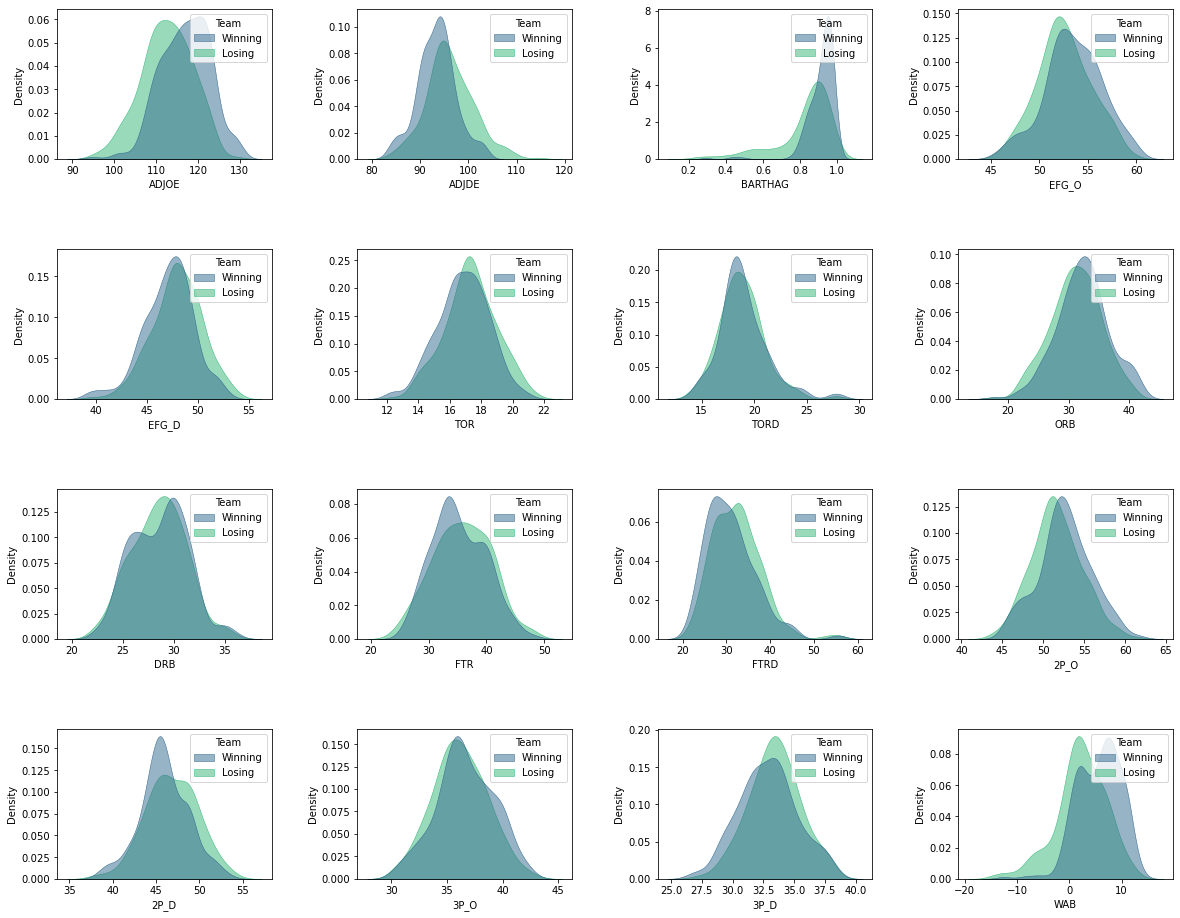

In [14]:
distCols = ['ADJOE', 'ADJDE', 'BARTHAG', 'EFG_O', 'EFG_D', 'TOR', 'TORD', 'ORB', 
            'DRB', 'FTR', 'FTRD', '2P_O', '2P_D', '3P_O', '3P_D', 'WAB']
fig, axs = plt.subplots(4, 4, figsize = (20, 16))
fig.subplots_adjust(hspace=.6, wspace=.4)
i, j = 0, 0
for col in distCols:
    cols = cbbEnhanced[['W_'+col, 'L_'+col]].stack().reset_index()
    cols.drop('level_0', axis = 1, inplace = True)
    cols.columns = ['Team', col]
    cols = cols.replace('W_' + col, 'Winning')
    cols = cols.replace('L_' + col, 'Losing')
    ax = sns.kdeplot(ax=axs[i, j],
       data=cols, x=col, hue = "Team",
       fill=True, common_norm=False, palette="viridis",
       alpha=.5, linewidth=.5,
    )
    j += 1
    if(j % 4 == 0):
        i += 1
        j = 0

plt.show()

### Mix Up Data

In [15]:
import random
cols = ['ADJOE', 'ADJDE', 'BARTHAG', 'EFG_O', 'EFG_D', 'TOR', 'TORD', 'ORB', 
        'DRB', 'FTR', 'FTRD', '2P_O', '2P_D', '3P_O', '3P_D', 'WAB']
randomdf = pd.DataFrame(columns = ['Season', 'WTeamID', 'WScore', 'LTeamID', 'LScore', 'NumOT', 'SeedDif',
       'W_CONF', 'W_G', 'W_W', 'W_ADJOE', 'W_ADJDE', 'W_BARTHAG', 'W_EFG_O',
       'W_EFG_D', 'W_TOR', 'W_TORD', 'W_ORB', 'W_DRB', 'W_FTR', 'W_FTRD',
       'W_2P_O', 'W_2P_D', 'W_3P_O', 'W_3P_D', 'W_ADJ_T', 'W_WAB',
       'W_POSTSEASON', 'W_SEED', 'L_CONF', 'L_G', 'L_W', 'L_ADJOE', 'L_ADJDE',
       'L_BARTHAG', 'L_EFG_O', 'L_EFG_D', 'L_TOR', 'L_TORD', 'L_ORB', 'L_DRB',
       'L_FTR', 'L_FTRD', 'L_2P_O', 'L_2P_D', 'L_3P_O', 'L_3P_D', 'L_ADJ_T',
       'L_WAB', 'L_POSTSEASON', 'L_SEED', 'Winning_Team', 'oneMinusZeroSeed'])
for i in range(len(cbbEnhanced)):
    choice = random.randint(0, 1)
    if choice == 0:
        W = '0_'
        L = '1_'
    else:
        W = '1_'
        L = '0_'
        
    
    newdf = cbbEnhanced.iloc[[i]]
    newdf.insert(0, "Winning_Team", [choice], True)
    if choice == 0:
        oneMZeroSeed = newdf.L_SEED.values[0] - newdf.W_SEED.values[0]
    else:
        oneMZeroSeed = newdf.W_SEED.values[0] - newdf.L_SEED.values[0]
    newdf.insert(1, "oneMinusZeroSeed", [oneMZeroSeed], True) 
    newdf.columns = newdf.columns.str.replace('W_', W)
    newdf.columns = newdf.columns.str.replace('L_', L)
    newdf.columns = newdf.columns.str.replace('WTeamID', W + 'TeamID')
    newdf.columns = newdf.columns.str.replace('LTeamID', L + 'TeamID')
    newdf.columns = newdf.columns.str.replace('LScore', L + 'Score')
    newdf.columns = newdf.columns.str.replace('RScore', W + 'Score')
    randomdf = randomdf.append(newdf, ignore_index = True)
randomdf.drop(['W_CONF', 'W_G', 'W_W', 'W_ADJOE', 'W_ADJDE', 'W_BARTHAG', 'W_EFG_O',
                'W_EFG_D', 'W_TOR', 'W_TORD', 'W_ORB', 'W_DRB', 'W_FTR', 'W_FTRD', 'WTeamID', 
                'WScore', 'LTeamID', 'LScore', 'W_2P_O', 'W_2P_D', 'W_3P_O', 'W_3P_D', 'W_ADJ_T', 
                'W_WAB', 'W_POSTSEASON', 'W_SEED', 'L_CONF', 'L_G', 'L_W', 'L_ADJOE', 'L_ADJDE',
                'L_BARTHAG', 'L_EFG_O', 'L_EFG_D', 'L_TOR', 'L_TORD', 'L_ORB', 'L_DRB',
                'L_FTR', 'L_FTRD', 'L_2P_O', 'L_2P_D', 'L_3P_O', 'L_3P_D', 'L_ADJ_T',
                'L_WAB', 'L_POSTSEASON', 'L_SEED', '1_POSTSEASON', '0_POSTSEASON', '0_CONF', '1_CONF', 'SeedDif'], axis = 1, inplace = True)
randomdf.dtypes
randomdf[['Season', 'NumOT', 'Winning_Team']]= randomdf[['Season', 'NumOT', 'Winning_Team']].astype(int)


In [43]:
X = randomdf[['1_TeamID', '0_TeamID', '1_G', '1_W', '1_ADJOE', '1_ADJDE',
       '1_BARTHAG', '1_EFG_O', '1_EFG_D', '1_TOR', '1_TORD', '1_ORB', '1_DRB',
       '1_FTR', '1_FTRD', '1_2P_O', '1_2P_D', '1_3P_O', '1_3P_D', '1_ADJ_T',
       '1_WAB', '1_SEED', '0_G', '0_W', '0_ADJOE', '0_ADJDE', '0_BARTHAG',
       '0_EFG_O', '0_EFG_D', '0_TOR', '0_TORD', '0_ORB', '0_DRB', '0_FTR',
       '0_FTRD', '0_2P_O', '0_2P_D', '0_3P_O', '0_3P_D', '0_ADJ_T', '0_WAB',
       '0_SEED', 'oneMinusZeroSeed']]
y = randomdf[['Winning_Team']]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train

,1_TeamID,0_TeamID,1_G,1_W,1_ADJOE,1_ADJDE,1_BARTHAG,1_EFG_O,1_EFG_D,1_TOR,...,0_FTR,0_FTRD,0_2P_O,0_2P_D,0_3P_O,0_3P_D,0_ADJ_T,0_WAB,0_SEED,oneMinusZeroSeed
183,1437.0,1403.0,40.0,36.0,128.4,94.1,0.9725,59.5,48.5,15.0,...,39.3,38.0,51.1,45.1,35.9,32.3,67.6,4.7,3.0,-2.0
201,1233.0,1314.0,33.0,17.0,105.2,108.8,0.4044,53.0,52.3,17.3,...,30.2,28.4,52.1,47.9,36.2,33.5,76.0,10.0,1.0,15.0
230,1403.0,1211.0,38.0,31.0,115.2,85.2,0.9696,53.5,43.0,17.7,...,35.3,25.9,61.4,43.4,36.3,30.4,72.0,7.0,1.0,2.0
95,1323.0,1343.0,36.0,26.0,119.3,96.4,0.9205,53.6,49.1,14.0,...,24.4,32.0,50.5,46.9,37.6,34.5,64.2,-0.4,12.0,-7.0
190,1436.0,1199.0,33.0,27.0,107.0,98.1,0.7324,52.6,48.7,16.8,...,35.8,35.7,50.9,45.3,33.2,33.5,70.0,7.6,4.0,9.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
106,1332.0,1233.0,38.0,33.0,117.8,93.8,0.9321,55.5,46.4,17.1,...,31.0,33.4,49.3,47.7,39.7,36.1,71.7,-5.8,14.0,-11.0
14,1234.0,1172.0,34.0,22.0,114.0,92.0,0.9211,48.1,45.6,17.1,...,28.5,34.6,53.1,51.4,38.7,30.0,67.2,1.7,10.0,-3.0
92,1315.0,1112.0,29.0,22.0,103.1,102.7,0.5112,53.4,50.7,18.3,...,40.5,28.6,51.5,48.4,39.0,31.0,67.1,7.9,2.0,13.0
179,1452.0,1437.0,37.0,26.0,120.9,95.8,0.9353,50.4,49.9,16.5,...,29.4,26.7,59.0,49.0,40.1,31.7,69.6,10.6,1.0,4.0


In [17]:
clf = LogisticRegression(random_state=0, solver='liblinear')
clf.fit(X_train, y_train.values.ravel())

LogisticRegression(random_state=0, solver='liblinear')

In [65]:
clf.score(X_test, y_test.values.ravel())

0.7916666666666666

In [69]:
results = {'pred_y': [], 'actual_y': []}
for i in range(len(X_test)):
    xtest = randomdf[['1_TeamID', '0_TeamID', '1_G', '1_W', '1_ADJOE', '1_ADJDE',
           '1_BARTHAG', '1_EFG_O', '1_EFG_D', '1_TOR', '1_TORD', '1_ORB', '1_DRB',
           '1_FTR', '1_FTRD', '1_2P_O', '1_2P_D', '1_3P_O', '1_3P_D', '1_ADJ_T',
           '1_WAB', '1_SEED', '0_G', '0_W', '0_ADJOE', '0_ADJDE', '0_BARTHAG',
           '0_EFG_O', '0_EFG_D', '0_TOR', '0_TORD', '0_ORB', '0_DRB', '0_FTR',
           '0_FTRD', '0_2P_O', '0_2P_D', '0_3P_O', '0_3P_D', '0_ADJ_T', '0_WAB',
           '0_SEED', 'oneMinusZeroSeed']].iloc[i, ]
    y = randomdf[['Winning_Team']].iloc[i, ]
    pred_y = clf.predict(np.array([xtest]))
    results['pred_y'].append(pred_y[0])
    results['actual_y'].append(y.values[0])
resids = pd.DataFrame(results)
resids['residual'] = resids['actual_y'] -  resids['pred_y']
resids.head()

,pred_y,actual_y,residual
0,0,0,0
1,1,1,0
2,0,0,0
3,0,0,0
4,1,1,0


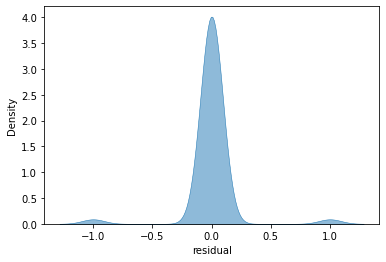

In [71]:
sns.kdeplot(
       data=resids, x='residual',
       fill=True, common_norm=False, palette="viridis",
       alpha=.5, linewidth=.5,
)
plt.show()

In [70]:
num_correct = resids.loc[abs(resids['residual']) < .5].count()[0]
total = resids.count()[0]
num_correct / total

0.9583333333333334

### ayy not awful, 95% correctness on the logistic regression

because i'm a nerd imma try neural networks

In [19]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing

In [20]:
norm = preprocessing.Normalization()
norm.adapt(np.array(X_train))
model = keras.Sequential([
        norm,
        layers.Dense(32, activation='relu'),
        layers.Dense(64, activation='relu'),
        layers.Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.L1(0.01),
                                            activity_regularizer=tf.keras.regularizers.L2(0.01)),
        layers.Dense(64, activation='relu', kernel_regularizer=tf.keras.regularizers.L1(0.01),
                                            activity_regularizer=tf.keras.regularizers.L2(0.01)),
        layers.Dense(32, activation='relu'),
        layers.Dense(1)
])

model.compile(loss='mean_squared_error', optimizer=tf.keras.optimizers.Adam(0.0001))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
normalization (Normalization (None, 43)                87        
_________________________________________________________________
dense (Dense)                (None, 32)                1408      
_________________________________________________________________
dense_1 (Dense)              (None, 64)                2112      
_________________________________________________________________
dense_2 (Dense)              (None, 128)               8320      
_________________________________________________________________
dense_3 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_4 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 3

In [21]:
def plot_loss(history, upper):
    plt.plot(history.history['loss'], label='loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    plt.ylim([0, upper])
    plt.xlabel('Epoch')
    plt.ylabel('Error')
    plt.legend()
    plt.grid(True)

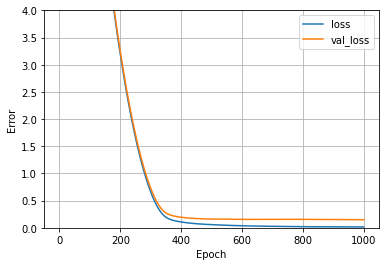

In [22]:
history = model.fit(
    X_train, y_train,
    validation_split=0.2,
    verbose=0, epochs=1000)
plot_loss(history, 4)


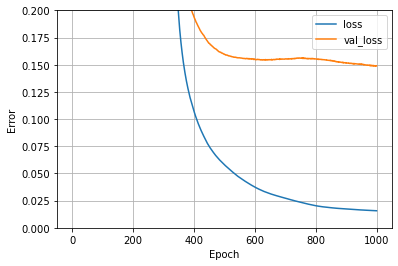

In [23]:
plot_loss(history, .2)

In [24]:
r2 = 1 - model.evaluate(X_test, y_test)
r2

2/2 [==============================] - 0s 500us/step - loss: 0.3173


0.6826729774475098

In [38]:

x_pred = randomdf[['1_TeamID', '0_TeamID', '1_G', '1_W', '1_ADJOE', '1_ADJDE',
       '1_BARTHAG', '1_EFG_O', '1_EFG_D', '1_TOR', '1_TORD', '1_ORB', '1_DRB',
       '1_FTR', '1_FTRD', '1_2P_O', '1_2P_D', '1_3P_O', '1_3P_D', '1_ADJ_T',
       '1_WAB', '1_SEED', '0_G', '0_W', '0_ADJOE', '0_ADJDE', '0_BARTHAG',
       '0_EFG_O', '0_EFG_D', '0_TOR', '0_TORD', '0_ORB', '0_DRB', '0_FTR',
       '0_FTRD', '0_2P_O', '0_2P_D', '0_3P_O', '0_3P_D', '0_ADJ_T', '0_WAB',
       '0_SEED', 'oneMinusZeroSeed']].iloc[1, ]
y_pred = randomdf[['Winning_Team']].iloc[1, ]
y_pred

Winning_Team    1
Name: 1, dtype: int32

In [39]:
y = model.predict(np.array([x_pred]), verbose = 1)
y

1/1 [==============================] - 0s 1ms/step


array([[1.0304021]], dtype=float32)

In [58]:
results = {'pred_y': [], 'actual_y': []}
for i in range(len(X_test)):
    xtest = randomdf[['1_TeamID', '0_TeamID', '1_G', '1_W', '1_ADJOE', '1_ADJDE',
           '1_BARTHAG', '1_EFG_O', '1_EFG_D', '1_TOR', '1_TORD', '1_ORB', '1_DRB',
           '1_FTR', '1_FTRD', '1_2P_O', '1_2P_D', '1_3P_O', '1_3P_D', '1_ADJ_T',
           '1_WAB', '1_SEED', '0_G', '0_W', '0_ADJOE', '0_ADJDE', '0_BARTHAG',
           '0_EFG_O', '0_EFG_D', '0_TOR', '0_TORD', '0_ORB', '0_DRB', '0_FTR',
           '0_FTRD', '0_2P_O', '0_2P_D', '0_3P_O', '0_3P_D', '0_ADJ_T', '0_WAB',
           '0_SEED', 'oneMinusZeroSeed']].iloc[i, ]
    y = randomdf[['Winning_Team']].iloc[i, ]
    pred_y = model.predict(np.array([xtest]))
    results['pred_y'].append(pred_y[0][0])
    results['actual_y'].append(y.values[0])
resids = pd.DataFrame(results)
resids['residual'] = resids['actual_y'] -  resids['pred_y']
resids.head()

,pred_y,actual_y,residual
0,0.002845,0,-0.002845
1,1.030402,1,-0.030402
2,0.002845,0,-0.002845
3,0.002845,0,-0.002845
4,1.003934,1,-0.003934


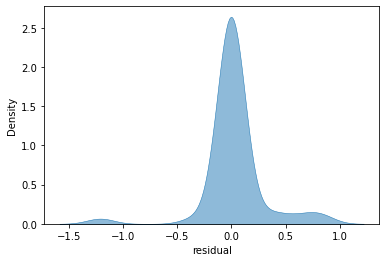

In [60]:
sns.kdeplot(
       data=resids, x='residual',
       fill=True, common_norm=False, palette="viridis",
       alpha=.5, linewidth=.5,
)
plt.show()

In [64]:
num_correct = resids.loc[abs(resids['residual']) < .5].count()[0]
total = resids.count()[0]
num_correct / total

0.9166666666666666

### on our test cases we predict games with 91% accuracy with NN! lets get it to 100% on either NN or LogReg

maybe add some dropout layers?
try some new layers?